### Random Forest
Random Forest has feature importance so just a quick test to see what could be most important, vs arthritis

In [ ]:
# Assuming combined_df is your DataFrame
arthritis_columns = [col for col in combined_df.columns if 'arthritis' in col.lower()]

# Display the found columns
combined_df[arthritis_columns]

,Doctor ever said you had arthritis [P_MCQ],Which type of arthritis was it? [P_MCQ]
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,2.0,NaN
4,2.0,NaN
...,...,...
15555,NaN,NaN
15556,NaN,NaN
15557,NaN,NaN
15558,NaN,NaN


In [ ]:
combined_df[arthritis_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15560 entries, 0 to 15559
Data columns (total 2 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Doctor ever said you had arthritis [P_MCQ]  9232 non-null   float64
 1   Which type of arthritis was it? [P_MCQ]     2812 non-null   float64
dtypes: float64(2)
memory usage: 243.3 KB


In [ ]:
combined_df['Doctor ever said you had arthritis [P_MCQ]'].value_counts()

Doctor ever said you had arthritis [P_MCQ]
2.0    6394
1.0    2812
9.0      26
Name: count, dtype: int64

In [ ]:
combined_df['Which type of arthritis was it? [P_MCQ]'].value_counts()

Which type of arthritis was it? [P_MCQ]
1.0    1182
9.0     692
2.0     574
4.0     316
3.0      45
7.0       3
Name: count, dtype: int64

In [ ]:
# It seems the first one is a better test for us
# Lets see how it does with the missing dropped, and also removing the answers of don't know so we can make it binary
rf_df = combined_df.copy()
rf_df.dropna(subset=['Doctor ever said you had arthritis [P_MCQ]'], inplace=True)
rf_df = rf_df[rf_df['Doctor ever said you had arthritis [P_MCQ]'] != 9.0]
rf_df['Doctor ever said you had arthritis [P_MCQ]'].value_counts()

Doctor ever said you had arthritis [P_MCQ]
2.0    6394
1.0    2812
Name: count, dtype: int64

              precision    recall  f1-score   support

         1.0       0.64      0.15      0.24       567
         2.0       0.72      0.96      0.82      1275

    accuracy                           0.71      1842
   macro avg       0.68      0.56      0.53      1842
weighted avg       0.69      0.71      0.64      1842

                                            Feature  Importance
732     Any metal objects inside your body? [P_MCQ]    0.022352
715   Age when 1st had gallbladder surgery? [P_MCQ]    0.007233
725             Doctor told you to exercise [P_MCQ]    0.006932
717          1st cancer - what kind was it? [P_MCQ]    0.005324
699  Ever told you had COPD, emphysema, ChB [P_MCQ]    0.005323
726  Doctor told you to reduce salt in diet [P_MCQ]    0.005018
680    Doctor ever said you were overweight [P_MCQ]    0.004809
714           Ever had gallbladder surgery? [P_MCQ]    0.004707
716  Ever told you had cancer or malignancy [P_MCQ]    0.004691
712          Ever seen a DR about

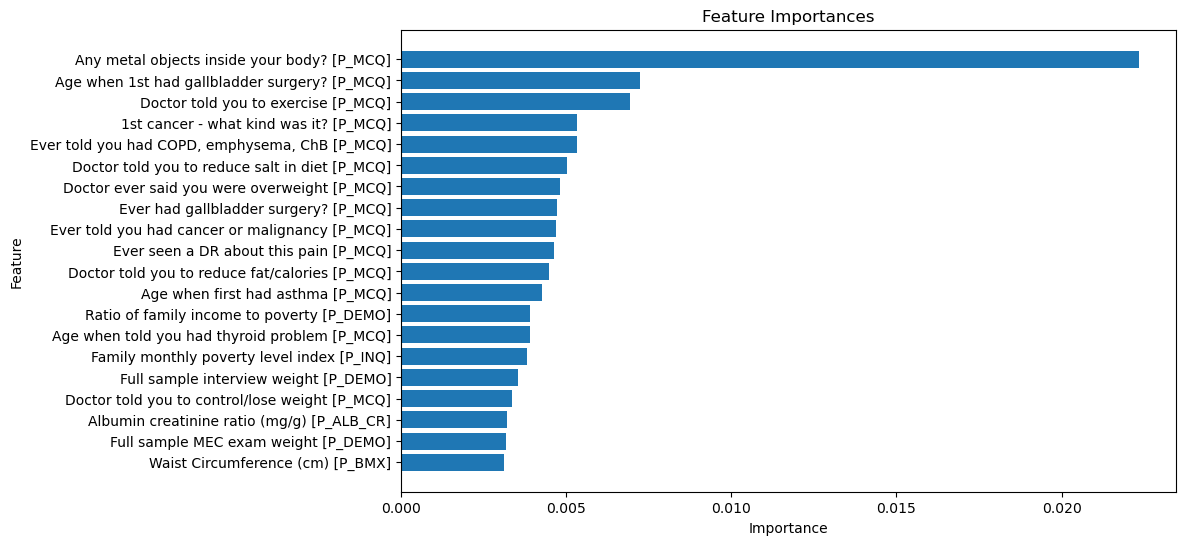

In [ ]:
# Define the feature matrix X and the target vector y
X = rf_df.drop(columns=['Doctor ever said you had arthritis [P_MCQ]'])
y = rf_df['Doctor ever said you had arthritis [P_MCQ]']

# this will make our model lean on this heavily for prediction, so dropping it
X.drop(columns=['Which type of arthritis was it? [P_MCQ]'],inplace=True)

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df.head(20)

# Display the feature importances
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

## XGBoost

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      2554
         1.0       0.57      0.40      0.47       558

    accuracy                           0.84      3112
   macro avg       0.72      0.67      0.69      3112
weighted avg       0.82      0.84      0.83      3112



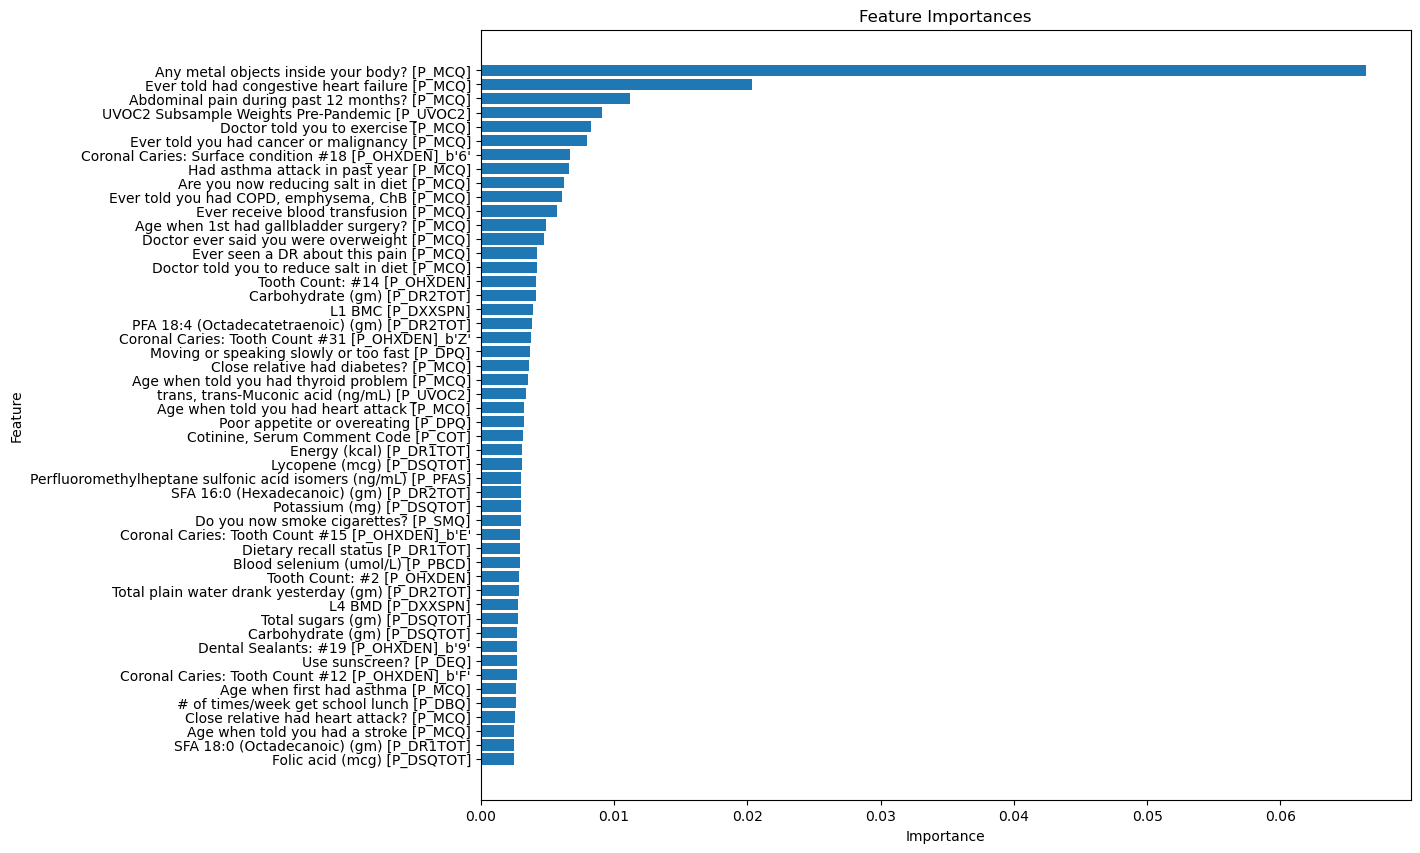

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Copy the combined_df DataFrame
xgboost_df = combined_df.copy()

# Define the feature matrix X and the target vector y
X = xgboost_df.drop(columns=['Doctor ever said you had arthritis [P_MCQ]'])
y = xgboost_df['Doctor ever said you had arthritis [P_MCQ]']

# Map 2, 9, and NaN to 0
y = y.map({1.0: 1, 2.0: 0, 9.0: 0})
y.fillna(0, inplace=True)

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Ensure all features are numeric and fill remaining NaNs with 0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X.drop(columns=['Which type of arthritis was it? [P_MCQ]'],inplace=True)

# Check for duplicate columns and rename them
def make_unique(column_names):
    seen = set()
    for i, col in enumerate(column_names):
        count = 1
        new_col = col
        while new_col in seen:
            new_col = f"{col}_{count}"
            count += 1
        seen.add(new_col)
        column_names[i] = new_col
    return column_names

X.columns = make_unique(list(X.columns))

# Capture the feature names after all transformations
feature_names = X.columns

# Convert to NumPy arrays
X = X.values
y = y.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = xgb.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] > 0]

# Display the feature importances
importance_df = importance_df.head(50)

# Plot the feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      2554
         1.0       0.57      0.40      0.47       558

    accuracy                           0.84      3112
   macro avg       0.72      0.67      0.69      3112
weighted avg       0.82      0.84      0.83      3112



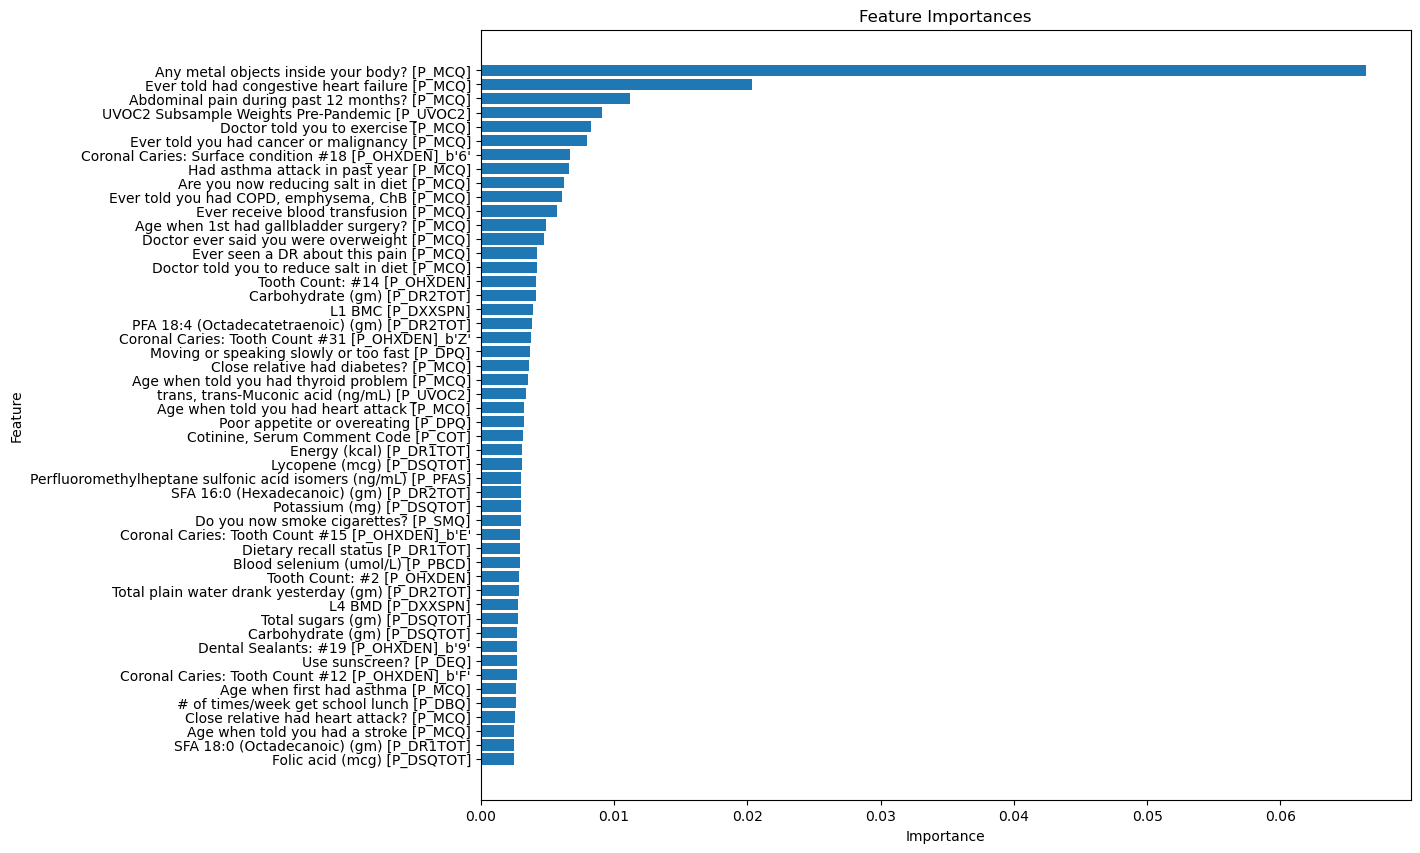

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Copy the combined_df DataFrame
xgboost_df = combined_df.copy()

# Define the feature matrix X and the target vector y
X = xgboost_df.drop(columns=['Doctor ever said you had arthritis [P_MCQ]'])
y = xgboost_df['Doctor ever said you had arthritis [P_MCQ]']

# Map 2, 9, and NaN to 0
y = y.map({1.0: 1, 2.0: 0, 9.0: 0})
y.fillna(0, inplace=True)

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Ensure all features are numeric and fill remaining NaNs with 0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X.drop(columns=['Which type of arthritis was it? [P_MCQ]'],inplace=True)

# Check for duplicate columns and rename them
def make_unique(column_names):
    seen = set()
    for i, col in enumerate(column_names):
        count = 1
        new_col = col
        while new_col in seen:
            new_col = f"{col}_{count}"
            count += 1
        seen.add(new_col)
        column_names[i] = new_col
    return column_names

X.columns = make_unique(list(X.columns))

# Capture the feature names after all transformations
feature_names = X.columns

# Convert to NumPy arrays
X = X.values
y = y.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = xgb.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] > 0]

# Display the feature importances
importance_df = importance_df.head(50)

# Plot the feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


In [ ]:
# Assuming combined_df is your DataFrame
autoimmune_columns = [col for col in combined_df.columns if 'autoimmune' in col.lower()]

# Display the found columns
combined_df[autoimmune_columns]


,Liver condition: Autoimmune hepatitis [P_MCQ]
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
15555,NaN
15556,NaN
15557,NaN
15558,NaN


In [ ]:
combined_df[autoimmune_columns].value_counts()

Liver condition: Autoimmune hepatitis [P_MCQ]
5.0                                              20
Name: count, dtype: int64

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
15555   NaN
15556   NaN
15557   NaN
15558   NaN
15559   NaN
Name: Liver condition: Autoimmune hepatitis [P_MCQ], Length: 15560, dtype: float64

,SEQN,Interview/Examination status [P_DEMO],Gender [P_DEMO],Age in years at screening [P_DEMO],Race/Hispanic origin w/ NH Asian [P_DEMO],Country of birth [P_DEMO],Length of time in US [P_DEMO],Education level - Adults 20+ [P_DEMO],Marital status [P_DEMO],Full sample interview weight [P_DEMO],...,Pain in left chest [P_CDQ],Pain in left arm [P_CDQ],Pain in epigastric area [P_CDQ],Severe pain in chest more than half hour [P_CDQ],Shortness of breath on stairs/inclines [P_CDQ],SEQN,Ever told you have Hepatitis B? [P_HEQ],Ever prescribed meds treat Hepatitis B? [P_HEQ],Ever told you have Hepatitis C? [P_HEQ],Ever prescribed meds treat Hepatitis C? [P_HEQ]
0,109263.0,2.0,1.0,2.0,6.0,1.0,NaN,NaN,NaN,7891.762435,...,NaN,NaN,NaN,2.0,1.0,109264.0,2.0,NaN,2.0,NaN
1,109264.0,2.0,2.0,13.0,1.0,1.0,NaN,NaN,NaN,11689.747264,...,NaN,NaN,NaN,NaN,2.0,109266.0,2.0,NaN,2.0,NaN
2,109265.0,2.0,1.0,2.0,3.0,1.0,NaN,NaN,NaN,16273.825939,...,NaN,NaN,NaN,2.0,1.0,109267.0,2.0,NaN,2.0,NaN
3,109266.0,2.0,2.0,29.0,6.0,2.0,2.0,5.0,3.0,7825.646112,...,NaN,NaN,NaN,1.0,1.0,109268.0,2.0,NaN,2.0,NaN
4,109267.0,1.0,2.0,21.0,2.0,2.0,3.0,4.0,3.0,26379.991724,...,NaN,NaN,NaN,NaN,2.0,109270.0,2.0,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15555,124818.0,2.0,1.0,40.0,4.0,1.0,NaN,5.0,1.0,21586.596728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15556,124819.0,2.0,1.0,2.0,4.0,1.0,NaN,NaN,NaN,1664.919253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15557,124820.0,2.0,2.0,7.0,3.0,1.0,NaN,NaN,NaN,14819.783161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15558,124821.0,2.0,1.0,63.0,4.0,1.0,NaN,2.0,2.0,4666.817952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Liver condition: Autoimmune hepatitis [P_MCQ]
5.0    20
Name: count, dtype: int64

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3112

    accuracy                           1.00      3112
   macro avg       1.00      1.00      1.00      3112
weighted avg       1.00      1.00      1.00      3112



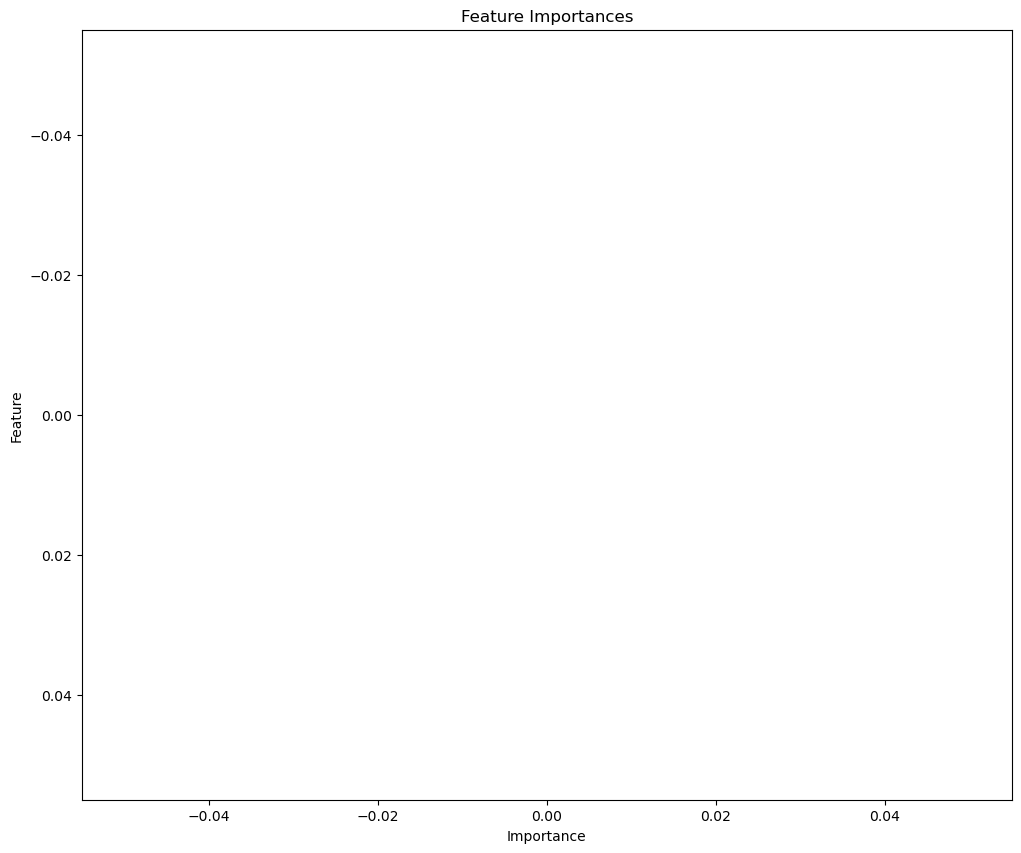

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Copy the combined_df DataFrame
xgboost_df = combined_df.copy()

# Define the feature matrix X and the target vector y
y = xgboost_df[autoimmune_columns[0]]
X = xgboost_df.drop(columns=[autoimmune_columns[0]])
display(y)
display(X)
display(y.value_counts())

# Map 2, 9, and NaN to 0
y = y.map({1.0: 1, 2.0: 0, 9.0: 0})
y.fillna(0, inplace=True)

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Ensure all features are numeric and fill remaining NaNs with 0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X.drop(columns=['Which type of arthritis was it? [P_MCQ]'],inplace=True)

# Check for duplicate columns and rename them
def make_unique(column_names):
    seen = set()
    for i, col in enumerate(column_names):
        count = 1
        new_col = col
        while new_col in seen:
            new_col = f"{col}_{count}"
            count += 1
        seen.add(new_col)
        column_names[i] = new_col
    return column_names

X.columns = make_unique(list(X.columns))

# Capture the feature names after all transformations
feature_names = X.columns

# Convert to NumPy arrays
X = X.values
y = y.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = xgb.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] > 0]

# Display the feature importances
importance_df = importance_df.head(50)

# Plot the feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


In [ ]:
def clean_dataframe(df):
    # Display the data types count in the original dataframe
    print("Data types before cleaning:")
    print(df.dtypes.value_counts())

    # Function to decode byte strings
    def decode_if_byte_string(value):
        if isinstance(value, bytes):
            return value.decode('utf-8')
        return value

    # Apply the function to the entire dataframe
    df = df.applymap(decode_if_byte_string)

    # Replace specified values with None
    df.replace({"": None, "None": None, "NaN": None, ".": None}, inplace=True)

    # Dictionary to store LabelEncoders
    label_encoders = {}

    # Create a mask for NaN values
    mask = df.isnull()

    # Convert object columns to int64 using LabelEncoder
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        non_null_values = df[col].dropna()
        le.fit(non_null_values)
        transformed_col = df[col].apply(lambda s: -1 if pd.isna(s) else le.transform([s])[0])
        df[col] = transformed_col.astype('int64')
        label_encoders[col] = le  # Store the LabelEncoder in the dictionary

    # Convert float columns with integer-like values to int64 with missing as -1
    for col in df.select_dtypes(include=['float']).columns:
        # Check if all non-NaN values can be converted to integers
        if df[col].dropna().apply(float.is_integer).all():
            df[col] = df[col].fillna(-1).astype('int64')

    # Display the data types count in the cleaned dataframe
    print("Data types after cleaning:")
    print(df.dtypes.value_counts())

    # Report on some of the encodings done, limited to the first 20 columns
    for col, le in list(label_encoders.items())[:20]:
        print(f"Column: {col}")
        encoding_dict = {original_value: le.transform([original_value])[0] for original_value in le.classes_}
        # Add NaN to -1 mapping if any NaN values are present in the column
        if mask[col].any():
            encoding_dict['NaN'] = -1
        print(encoding_dict)
        print(df[col].value_counts())

    return df, label_encoders

cleaned_df = combined_df.copy()
cleaned_df, label_encoders = clean_dataframe(cleaned_df)

## Feature Selection Intuition via Catboost
We have so many columns still, but one trick we can do is load it into catboost because it does a lot of preprocessing and missing handling for you.

This could give us more intuition on which features to select for a final model.

In [ ]:

# Custom transformer to remove rows with -1 in y
class RemoveNegatives(BaseEstimator, TransformerMixin):
    def __init__(self, enabled=True):
        self.enabled = enabled
    
    def fit(self, X, y=None):
        if self.enabled and y is not None:
            self.indices_to_keep_ = y != -1
        else:
            self.indices_to_keep_ = np.ones(len(X), dtype=bool)
        return self
    
    def transform(self, X, y=None):
        if self.enabled:
            X_transformed = X[self.indices_to_keep_]
            if y is not None:
                y_transformed = y[self.indices_to_keep_]
                return X_transformed, y_transformed
        return X, y


In [ ]:
run_catboost = False

In [ ]:
if run_catboost:
    # Define the feature matrix X and the target vector y
    X = combined_df.drop(columns=['Doctor ever said you had arthritis [P_MCQ]'])
    y = combined_df['Doctor ever said you had arthritis [P_MCQ]']
    X.drop(columns=['Which type of arthritis was it? [P_MCQ]'],inplace=True)

    # Map 2, 9, and NaN to 0
    y = y.map({1.0: 1, 2.0: 0, 9.0: 0})
    y.fillna(0, inplace=True)

    # Convert categorical variables to string and handle NaNs
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    X[categorical_features] = X[categorical_features].astype(str).fillna('NaN')

    # Convert numeric columns to float (this will also handle any remaining NaNs in numeric columns)
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    X[numeric_features] = X[numeric_features].fillna(0)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the CatBoost Classifier
    catboost_model = CatBoostClassifier(random_state=42, eval_metric='Logloss', cat_features=categorical_features, verbose=0)

    # Train the model
    catboost_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = catboost_model.predict(X_test)

    # Print the classification report
    print(classification_report(y_test, y_pred))

    # Get feature importances
    feature_importances = catboost_model.get_feature_importance()

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(importance_df)
    filtered_importance_df = importance_df[importance_df['Importance'] > 0.3]
    filtered_importance_df = importance_df.head(65)

    # Plot the feature importances
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 20))
    plt.barh(filtered_importance_df['Feature'], filtered_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
    plt.show()

Interesting, I am seeing a lot of age related features high up in the list.  

Using sunscreen is an interesting one!

This is just for intuition though.  The results will likely look much different after we properly do EDA and cleaning.

In [ ]:
# Define the Keras model function
def create_model(optimizer='adam', dropout_rate=0.0, init_mode='uniform'):
    model = Sequential()
    model.add(Dense(64, input_dim=pX_train.shape[1], kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))  # Assuming binary classification
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the Keras model
classifier = KerasClassifier(model=create_model, verbose=0)

# Define the full pipeline with the correct order of steps
full_pipeline = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Placeholder, will be varied in grid search
    ('smote', SMOTE()),  # Apply SMOTE
    ('scaler', StandardScaler()),  # Standardize the data
    ('classifier', classifier)  # Keras classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'imputer__strategy': ['mean', 'median'],  # Varying the imputation strategy
    'smote__k_neighbors': [3, 5],  # Varying the number of neighbors in SMOTE
    'classifier__model__optimizer': ['adam', 'sgd'],  # Varying the optimizer
    'classifier__model__dropout_rate': [0.0, 0.2],  # Varying the dropout rate
    'classifier__model__init_mode': ['uniform', 'normal'],  # Varying the weight initialization mode
    'classifier__batch_size': [32, 64],  # Varying the batch size
    'classifier__epochs': [10, 20]  # Varying the number of epochs
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search_nn = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=2)  # Reduced to 2 jobs

# Fit the GridSearchCV
grid_search_nn.fit(pX_train, y_train)

# Display the best parameters and the best score
print(f"Best parameters: {grid_search_nn.best_params_}")
print(f"Best score (Accuracy): {grid_search_nn.best_score_}")

2024-07-30 13:39:51.429030: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 13:39:51.454730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 13:39:51.454757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 13:39:51.455932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 13:39:51.459990: I tensorflow/core/platform/cpu_feature_gua

MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /home/atrix/anaconda3/envs/rapids_24.06/include/rmm/mr/device/cuda_memory_resource.hpp:60: cudaErrorMemoryAllocation out of memory

In [ ]:
# Check for NaNs and Infs in the data
def check_for_nans_and_infs(X):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        raise ValueError("Data contains NaNs or infinite values. Please check your data preprocessing steps.")

# Remove or impute NaNs and infinite values
def clean_data(X):
    X[np.isinf(X)] = np.nan
    X = np.where(np.isnan(X), np.nanmean(X, axis=0), X)
    return X

# Remove constant features
def remove_constant_features(X):
    non_constant_mask = np.std(X, axis=0) != 0
    return X[:, non_constant_mask], non_constant_mask

# Remove highly correlated features
def remove_highly_correlated_features(X, threshold=0.95):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_tri = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    to_remove = [i for i in range(corr_matrix.shape[1]) if any(np.abs(corr_matrix[i, j]) > threshold for j in range(i))]
    return np.delete(X, to_remove, axis=1), np.delete(np.arange(corr_matrix.shape[1]), to_remove)

# Clean and prepare the data
X2 = np.append(np.ones((fX_train_no_missing.shape[0], 1)), fX_train_no_missing, axis=1)
X2 = clean_data(X2)
check_for_nans_and_infs(X2)

# Get feature names including the intercept
feature_names = np.array(['Intercept'] + list(fX_train_no_missing.columns))

# Remove constant features
X2, non_constant_mask = remove_constant_features(X2)
feature_names = feature_names[non_constant_mask]

# Remove highly correlated features
X2, remaining_indices = remove_highly_correlated_features(X2)
feature_names = feature_names[remaining_indices]

# Standardize the features
scaler = StandardScaler()
X2[:, 1:] = scaler.fit_transform(X2[:, 1:])

# Extract best parameters from GridSearchCV (assumed to be stored in best_params_)
best_params_ = grid_search_logistic.best_params_

# Set up the logistic regression model in statsmodels with the best parameters
model = sm.Logit(y_train_no_missing, X2)

# Fit the logistic regression model using statsmodels with increased iterations and a different optimization method
result = model.fit(maxiter=10000, method='lbfgs', disp=False)  # Use 'lbfgs' method for better convergence

# Extract p-values
p_values = result.pvalues

# Identify significant features
significant_features = feature_names[p_values < 0.05]

# List of features that predict the 1 class (risk factors for arthritis)
risk_factors = significant_features[1:]  # Exclude the intercept

print("Risk factors for arthritis (p < 0.05):", risk_factors.tolist())

Risk factors for arthritis (p < 0.05): ['Gender [P_DEMO]', 'Age in years at screening [P_DEMO]', 'Country of birth [P_DEMO]', 'Education level - Adults 20+ [P_DEMO]', 'Moisture (gm) [P_DR1TOT]', 'SFA 8:0 (Octanoic) (gm) [P_DR1TOT]', 'SFA 12:0 (Dodecanoic) (gm) [P_DR1TOT]', 'Total # of Dietary Supplements Taken [P_DSQTOT]', 'Total # of Antacids Taken [P_DSQTOT]', 'Tooth Count: #12 [P_OHXDEN]', 'Coronal Caries: Tooth Count #24 [P_OHXDEN]', 'Albumin creatinine ratio (mg/g) [P_ALB_CR]', 'White blood cell count (1000 cells/uL) [P_CBC]', 'Lymphocyte number (1000 cells/uL) [P_CBC]', 'Monocyte number (1000 cells/uL) [P_CBC]', 'Segmented neutrophils number (1000 cells/uL) [P_CBC]', 'Red cell distribution width (%) [P_CBC]', 'Blood cadmium (ug/L) [P_PBCD]', 'Potassium (mmol/L) [P_BIOPRO]', 'Blood ever tested for HIV virus? [P_HSQ]', 'Moderate recreational activities [P_PAQ]', 'Trouble sleeping or sleeping too much [P_DPQ]', 'Poor appetite or overeating [P_DPQ]', 'Moving or speaking slowly or too

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Check for NaNs and Infs in the data
def check_for_nans_and_infs(X):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        raise ValueError("Data contains NaNs or infinite values. Please check your data preprocessing steps.")

# Remove or impute NaNs and infinite values
def clean_data(X):
    # Replace infinite values with NaNs
    X[np.isinf(X)] = np.nan
    # Impute NaNs with the mean of the column (or use another imputation method)
    X = np.where(np.isnan(X), np.nanmean(X, axis=0), X)
    return X

# Calculate VIF and remove multicollinear features
def remove_multicollinear_features(X, feature_names, threshold=10.0):
    X_df = pd.DataFrame(X, columns=feature_names)
    vif = pd.DataFrame()
    vif["Feature"] = X_df.columns
    vif["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    while vif["VIF"].max() > threshold:
        max_vif_feature = vif.sort_values("VIF", ascending=False).iloc[0]
        print(f"Removing {max_vif_feature['Feature']} with VIF={max_vif_feature['VIF']}")
        X_df = X_df.drop(columns=[max_vif_feature["Feature"]])
        vif = pd.DataFrame()
        vif["Feature"] = X_df.columns
        vif["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    return X_df.values, X_df.columns

# Prepare the data for statsmodels
X2 = np.append(np.ones((fX_train_no_missing.shape[0], 1)), fX_train_no_missing, axis=1)

# Clean the data
X2 = clean_data(X2)

# Verify that the data is now clean
check_for_nans_and_infs(X2)

# Get feature names including the intercept
feature_names = np.array(['Intercept'] + list(fX_train_no_missing.columns))

# Remove multicollinear features
X2, feature_names = remove_multicollinear_features(X2, feature_names)

# Fit the logistic regression model using statsmodels
model = sm.Logit(y_train_no_missing, X2)
result = model.fit()

# Extract p-values
p_values = result.pvalues

# Identify significant features
significant_features = feature_names[p_values < 0.05]

# List of features that predict the 1 class (risk factors for arthritis)
risk_factors = significant_features[1:]  # Exclude the intercept

print("Risk factors for arthritis (p < 0.05):", risk_factors.tolist())

/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing Total Protein (g/dL) [P_BIOPRO] with VIF=inf


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing Albumin, urine (ug/mL) [P_ALB_CR] with VIF=inf


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing Globulin (g/dL) [P_BIOPRO] with VIF=inf


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing Creatinine, urine (mg/dL) [P_ALB_CR] with VIF=inf


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing Ferritin (ug/L) [P_FERTIN] with VIF=inf


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing Total plain water drank yesterday (gm) [P_DR1TOT] with VIF=inf


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing Total Calcium (mmol/L) [P_BIOPRO] with VIF=inf


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing Total Bilirubin Comment Code [P_BIOPRO] with VIF=inf


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing Blood selenium comment code [P_PBCD] with VIF=inf


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Blood manganese (ug/L) [P_PBCD] with VIF=558627919.040188


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Blood cadmium (ug/L) [P_PBCD] with VIF=310887327.24480027


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Creatinine, refrigerated serum (umol/L) [P_BIOPRO] with VIF=292454314.8782084


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Total Protein (g/L) [P_BIOPRO] with VIF=168189496.18008018


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Triglycerides, refrigerated serum (mg/dL) [P_BIOPRO] with VIF=20851013.120701082


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Blood mercury, total (ug/L) [P_PBCD] with VIF=16737535.13674069


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Uric acid (umol/L) [P_BIOPRO] with VIF=9776591.891182728


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Cholesterol, refrigerated serum (mg/dL) [P_BIOPRO] with VIF=1722748.2243968311


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing UIBC, Serum (ug/dL) [P_FETIB] with VIF=705630.7531708098


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Blood Urea Nitrogen (mg/dL) [P_BIOPRO] with VIF=666986.3627189975


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Phosphorus (mg/dL) [P_BIOPRO] with VIF=384497.74511869485


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Glucose, refrigerated serum (mg/dL) [P_BIOPRO] with VIF=223482.43605469758


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Vitamin A, RAE (mcg) [P_DR1TOT] with VIF=154111.0185600517


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Folate, DFE (mcg) [P_DR1TOT] with VIF=99262.77643835335


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Blood lead (umol/L) [P_PBCD] with VIF=42804.93058365768


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removing Segmented neutrophils percent (%) [P_CBC] with VIF=30996.496172641648


/home/atrix/anaconda3/envs/rapids_24.06/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


KeyboardInterrupt: 

In [ ]:
## replace infinites
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

def replace_negative_ones_with_nan(X):
    return X.replace(-1, np.nan)

def handle_missing_and_infinite_values(X):
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    X = X.replace([np.inf, -np.inf], np.nan)
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    return X

# Assuming fX_train_no_missing and y_train_no_missing are your training data
fX_train_no_missing = replace_negative_ones_with_nan(fX_train_no_missing)
fX_train_no_missing = handle_missing_and_infinite_values(fX_train_no_missing)

# Save the processed data for the next step
fX_train_no_missing.to_pickle('fX_train_no_missing_processed.pkl')


In [ ]:
def check_for_nans_and_infs(X):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        raise ValueError("Data contains NaNs or infinite values. Please check your data preprocessing steps.")

if run_logistic:
    # Define the full pipeline with the correct order of steps
    full_pipeline_logistic = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('smote', SMOTE()),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(solver='liblinear'))
    ])

    # Define the parameter grid for GridSearchCV
    param_grid_logistic = {
        'imputer__strategy': ['mean', 'median'],
        'smote__k_neighbors': [3, 5],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search_logistic = GridSearchCV(full_pipeline_logistic, param_grid_logistic, cv=3, scoring='f1', n_jobs=-1)

    # Fit the GridSearchCV
    grid_search_logistic.fit(fX_train_no_missing, y_train_no_missing)

    # Display the best parameters and the best score
    print(f"Best parameters: {grid_search_logistic.best_params_}")
    print(f"Best score (F1): {grid_search_logistic.best_score_}")

    # Predict on the test set with the best logistic regression model
    y_pred_logistic = grid_search_logistic.best_estimator_.predict(fX_test_no_missing)

    # Generate the classification report and confusion matrix
    logistic_classification_report = classification_report(y_test_no_missing, y_pred_logistic)
    logistic_confusion_matrix = confusion_matrix(y_test_no_missing, y_pred_logistic)

    print("Logistic Regression Classification Report:\n", logistic_classification_report)
    print("Confusion Matrix:\n", logistic_confusion_matrix)

    # Save the best model to a folder called "models" as a pickle file
    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, 'logistic_model.pkl')

    with open(model_path, 'wb') as model_file:
        pickle.dump(grid_search_logistic.best_estimator_, model_file)

    print(f"Best model saved to {model_path}")

Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'imputer__strategy': 'mean', 'smote__k_neighbors': 5}
Best score (F1): 0.6479369589222398
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.74      0.81      1295
           1       0.57      0.79      0.66       569

    accuracy                           0.75      1864
   macro avg       0.73      0.76      0.73      1864
weighted avg       0.79      0.75      0.76      1864

Confusion Matrix:
 [[956 339]
 [122 447]]
Best model saved to models/logistic_model.pkl


I need help updating the notebook and making a presentation
here's the rubric:
Phase 4 Project Description
GitHub RepoCreate New Issue

Final phase down -- you're absolutely crushing it! You've made it all the way through one of the toughest phases of this course. You must have an amazing brain in your head!

You have one last project to complete before the Capstone. In this project description, we will cover:

    Project Overview
    Deliverables
    Grading
    Getting Started

Project Overview

For this project, you will engage in an advanced supervised modeling process from start to finish, solving either a classification or a regression problem using an advanced dataset.
Business Problem and Data

Similar to the Phase 3 project, you are responsible for choosing a dataset as well as defining a stakeholder and business problem. In addition to these choices, you can choose between any of the advanced supervised modeling techniques covered in Phase 4:

    Recommendation Systems
    Model Interpretability
    Natural Language Processing

You should also think about how you will interpret and explain your models results to your audience.

For complete details, see Phase 4 Project - Choosing a Dataset

Links to an external site..
Key Points
Advanced Data Types and Modeling

The purpose of this project is to demonstrate that you have mastered the basics of some type of modeling technique beyond the techniques introduced in Phase 3. This is your chance to tailor your work to a data science audience in particular, with a clear notebook narrative that illustrates your process. The resulting presentation slides will be substantially similar to a Phase 3 presentation, but someone reading your notebook should be able to see your grasp of the specific advanced modeling technique.
Validation Strategy

A validation strategy means a strategy to demonstrate that your model will actually perform well on unseen data. You could use the train_test_split function from scikit-learn. This may or may not be appropriate for the project you select. Make sure that you are thinking about this strategy from the start and incorporating it into your notebook narrative.
Choosing a Dataset

We've given you a lot of choices - don't get stuck spending too much time choosing which project to do. Give yourself a firm time limit for picking a project (e.g. 2 hours) so you can get on with making something great. Don't worry about picking the perfect project - remember that you will get to do a new, larger Capstone project very soon!
The Deliverables

There are three deliverables for this project:

    A non-technical presentation
    A Jupyter Notebook
    A GitHub repository

The checklist of requirements for Phase 4 will are outlined below, and this will also be the checklist for Capstone.
Non-Technical Presentation

The non-technical presentation should be very similar to the presentation you gave in Phase 3. You can feel free to mention the specific models and metrics you used, but make sure you translate everything for an audience who is not familiar with data science.
Jupyter Notebook

The notebook will have the same checklist elements as in Phase 3. However, this time around the Communication rubric element will focus on the technical notebook. A data science professional reading your notebook should be able to understand all of your data preparation and modeling decisions.
GitHub Repository

The GitHub repository should also be very similar to the Phase 3 repository.

The main additional element to consider is reproducibility, since many of the dataset options are too large to be saved directly in a GitHub repository. Make sure you include clear instructions for how someone would reproduce your modeling process, potentially including any scripts you used to organize data into directories.
Grading

To pass this project, you must pass each rubric objective. The project rubric objectives for Phase 4 are:

    Advanced ML Communication
    Advanced Data Preparation
    Advanced ML Modeling

Advanced ML Communication

You are expected to communicate the results of an ML modeling process. We are looking for rationale, results, limitations, and recommendations.

In Phase 4, the emphasis is on the Jupyter Notebook. The notebook should include a summary at the beginning that briefly and accurately describes your process. The summary should be approximately 250 words -- about the size of a research paper abstract.

Summary elements:

    Business and data understanding: what kind of data are you using, and what makes it well-suited for the business problem?
        You do not need to include any data visualizations in your summary, but consider including relevant descriptive statistics
    Data preparation: why did you choose the data preparation steps that you did, and what was the result?
        This should be specific to the kind of data you are working with. For example, if you are doing an NLP project, what did you decide to do with stopwords?
        Be sure to list the packages/libraries used to prepare the data, and why
    Modeling: what modeling package(s) did you use, which model(s) within the package(s), and what tuning steps did you take?
        For some projects there may be only one applicable package; you should still briefly explain why this was the appropriate choice
    Evaluation: how well did your final model perform?
        Include one or more relevant metrics
        Be sure to briefly describe your validation approach

Exceeds Objective

Communicates advanced modeling summary as well as a narrative throughout the notebook text that demonstrates mastery of an advanced topic

    Decisions should be justified and outcomes evaluated in Markdown throughout the notebook

Meets Objective (Passing Bar)

Successfully communicates a summary of an advanced modeling technique including business and data understanding, data preparation, modeling, and evaluation

    It is possible to meet this bar with just a summary and not a narrative throughout the notebook, so long as the steps taken are justifiable and free of major errors. See the Approaching Objective section for an explanation of what a "major error" means.

Approaching Objective

Communicates advanced modeling summary with at least one major error

    A major error means that one of the required elements of the summary was missing, or some aspect of the communication was fundamentally incorrect. For example, if you stated that you performed "deep learning" when you actually used CountVectorizer and MultinomialNB from scikit-learn, that would be a major error. Another example would be if you described a regression task as a classification task, or if you described supervised learning as unsupervised learning.

Does Not Meet Objective

Does not communicate advanced modeling summary

    Markdown headings and occasional narrative text throughout the notebook are not sufficient in this phase, even if they were in previous phases. You need to include a summary at the beginning of your notebook.

Advanced Data Preparation

Once again, this objective is very similar to Phase 3, although the complexity has increased.
Exceeds Objective

Goes above and beyond with data preparation, such as feature engineering, using pipelines, or using unsupervised techniques

    Supervised learning is the core of this project, but feel free to use unsupervised techniques for data analysis or preparation

Meets Objective (Passing Bar)

Successfully prepares data for modeling, using at least one Python package other than scikit-learn

    Your final model does not need to use anything other than scikit-learn, but you should explore other tools during your modeling process

Approaching Objective

Prepares some data successfully, but has at least one major error
Does Not Meet Objective

Does not prepare data for modeling
Advanced ML Modeling

This is your real opportunity to flex those new Phase 4 skills!
Exceeds Objective

Goes above and beyond in the modeling process, such as using models from multiple different packages and different model explainability tools

    You are encouraged but not required to use models from multiple different packages. The feasibility of this depends on your choice of project. For time series, this might mean trying both StatsModels and Prophet. For image classification, this might mean using TensorFlow with and without transfer learning.

    See this book chapter 

    Links to an external site. for an introduction to LIME for model explainability

Meets Objective (Passing Bar)

Successfully builds and evaluates multiple models using an appropriate model validation technique and uses built in model explainability tools

    As noted previously, the train_test_split from scikit-learn may or may not be appropriate for your modeling task. Be sure to investigate appropriate techniques so you are confident in the performance of your final model on unseen data

Approaching Objective

Builds multiple models with at least one major error
Does Not Meet Objective

Does not build multiple models and does not use model explanability
Getting Started

Please start by reviewing the contents of this project description. If you have any questions, please ask your instructor ASAP.

Once you are ready to begin the project, you will need to complete the Project Proposal.

Recall that more information is available in Phase 4 Project - Choosing a Dataset

Links to an external site..

To get started with project development, create a new repository on GitHub. For this project, we recommend that you do not fork the template repository, but rather that you make a new repository from scratch, starting by going to github.com/new

Links to an external site..
Summary

This project is your chance to show off your data science prowess with some advanced machine learning algorithms. Now that you've gone through all of the core course content, we're excited to see what you are able to do!


Topic 2: Model Interpretability

If you choose this option, you'll put everything you've learned together to build and explain a model that is trained on a dataset. In this case, your model will explain the underlying causes in vehicle crashes. The dataset comes from the City of Chicago
Links to an external site.. Note this links also to Vehicle Data Links to an external site. and to Driver/Passenger Data

Links to an external site..

Your task is to:

    Build a model that can predict the primary contributory cause of a car accident, given information about the car, the people in the car, the road conditions etc. You might imagine your audience as a Vehicle Safety Board who's interested in reducing traffic accidents, or as the City of Chicago who's interested in becoming aware of any interesting patterns.
    Aim for a Proof of Concept

The goal of this project isn't to build the best model possible -- it's to demonstrate your understanding of the model that works. You should try to avoid datasets and model architectures that won't run in reasonable time on your own machine. Once you're absolutely sure that you've found the best possible hyperparameters for your model, then consider leveraging model interpretability to gain insight to why the model is making predictions in that manner it does.

At the end of the day, we want to see your thought process as you iterate and improve on a model. A project that achieves a lower level of accuracy but has clearly iterated on the model and the problem until it found the best possible approach is more impressive than a model with high accuracy that did no iteration. We're not just interested in seeing you finish a model -- we want to see that you understand it, and can use this knowledge to try and make it even better!
Evaluation

Evaluation is fairly straightforward for this project. But you'll still need to think about which metric to use and about how best to cross-validate your results.

Deliverables

There are three deliverables for this project:

    A non-technical presentation
    A Jupyter Notebook
    A GitHub repository
    An Interactive Dashboard

Non-Technical Presentation

The non-technical presentation is a slide deck presenting your analysis to business stakeholders.

    Non-technical does not mean that you should avoid mentioning the technologies or techniques that you used, it means that you should explain any mentions of these technologies and avoid assuming that your audience is already familiar with them.
    Business stakeholders means that the audience for your presentation is the business, not the class or teacher. Do not assume that they are already familiar with the specific business problem.

The presentation describes the project goals, data, methods, and results. It must include at least three visualizations which correspond to three business recommendations.

We recommend that you follow this structure, although the slide titles should be specific to your project:

    Beginning
        Overview
        Business Understanding
    Middle
        Data Understanding
        Data Analysis
    End
        Recommendations
        Next Steps
        Thank You
            This slide should include a prompt for questions as well as your contact information (name and LinkedIn profile)

You will give a live presentation of your slides and submit them in PDF format on Canvas. The slides should also be present in the GitHub repository you submit with a file name of presentation.pdf.

The graded elements of the presentation are:

    Presentation Content
    Slide Style
    Presentation Delivery and Answers to Questions

See the Grading section for further explanation of these elements.

For further reading on creating professional presentations, check out:

    Presentation Content
    Slide Style

Jupyter Notebook

The Jupyter Notebook is a notebook that uses Python and Markdown to present your analysis to a data science audience.

    Python and Markdown means that you need to construct an integrated .ipynb file with Markdown (headings, paragraphs, links, lists, etc.) and Python code to create a well-organized, skim-able document.
        The notebook kernel should be restarted and all cells run before submission, to ensure that all code is runnable in order.
        Markdown should be used to frame the project with a clear introduction and conclusion, as well as introducing each of the required elements.
    Data science audience means that you can assume basic data science proficiency in the person reading your notebook. This differs from the non-technical presentation.

Along with the presentation, the notebook also describes the project goals, data, methods, and results.

You will submit the notebook in PDF format on Canvas as well as in .ipynb format in your GitHub repository.

The graded elements for the Jupyter Notebook are:

    Business Understanding
    Data Understanding
    Data Preparation
    Data Analysis
    Code Quality

See the Grading section for further explanation of these elements.
GitHub Repository

The GitHub repository is the cloud-hosted directory containing all of your project files as well as their version history.

This repository link will be the project link that you include on your resume, LinkedIn, etc. for prospective employers to view your work. Note that we typically recommend that 3 links are highlighted (out of 5 projects) so don't stress too much about getting this one to be perfect! There will also be time after graduation for cosmetic touch-ups.

A professional GitHub repository has:

    README.md
        A file called README.md at the root of the repository directory, written in Markdown; this is what is rendered when someone visits the link to your repository in the browser
        This file contains these sections:
            Overview
            Business Understanding
                Include stakeholder and key business questions
            Data Understanding and Analysis
                Source of data
                Description of data
                Three visualizations (the same visualizations presented in the slides and notebook)
            Conclusion
                Summary of conclusions including three relevant findings
    Commit history
        Progression of updates throughout the project time period, not just immediately before the deadline
        Clear commit messages
        Commits from all team members (if a group project)
    Organization
        Clear folder structure
        Clear names of files and folders
        Easily-located notebook and presentation linked in the README
    Notebook(s)
        Clearly-indicated final notebook that runs without errors
        Exploratory/working notebooks (can contain errors, redundant code, etc.) from all team members (if a group project)
    .gitignore
        A file called .gitignore at the root of the repository directory instructs Git to ignore large, unnecessary, or private files
            Because it starts with a ., you will need to type ls -a in the terminal in order to see that it is there
        GitHub maintains a Python .gitignore that may be a useful starting point for your version of this file
        To tell Git to ignore more files, just add a new line to .gitignore for each new file name
            Consider adding .DS_Store if you are using a Mac computer, as well as project-specific file names
            If you are running into an error message because you forgot to add something to .gitignore and it is too large to be pushed to GitHub this blog post(friend link) should help you address this

You wil submit a link to the GitHub repository on Canvas.

See the Grading section for further explanation of how the GitHub repository will be graded.

For further reading on creating professional notebooks and READMEs, check out this reading.

### Risk Factors for Arthritis (p < 0.05)

#### Demographic and Socioeconomic Factors
1. **Gender**
2. **Age**
3. **Country of Birth**
4. **Education Level**
5. **Family Monthly Poverty Level Category**

#### Dietary and Nutritional Factors
6. **Moisture (gm)**
7. **SFA 8:0 (Octanoic) (gm)**
8. **SFA 12:0 (Dodecanoic) (gm)**
9. **Total # of Dietary Supplements Taken**
10. **Total # of Antacids Taken**

#### Dental Health
11. **Tooth Count: #12**
12. **Coronal Caries: Tooth Count #24**

#### Biomarkers and Blood Tests
13. **Albumin Creatinine Ratio**
14. **White Blood Cell Count**
15. **Lymphocyte Number**
16. **Monocyte Number**
17. **Segmented Neutrophils Number**
18. **Red Cell Distribution Width**
19. **Blood Cadmium**
20. **Potassium**

#### Health and Lifestyle Factors
21. **Blood Ever Tested for HIV Virus?**
22. **Moderate Recreational Activities**
23. **Trouble Sleeping or Sleeping Too Much**
24. **Poor Appetite or Overeating**
25. **Moving or Speaking Slowly or Too Fast**
26. **Ever Been Told You Have Asthma**
27. **Abdominal Pain During Past 12 Months?**
28. **Ever Had Gallbladder Surgery?**
29. **Close Relative Had Asthma?**
30. **Close Relative Had Diabetes?**
31. **Doctor Told You to Exercise**
32. **Are You Now Reducing Salt in Diet?**
33. **Self-Reported Weight-Age 25**
34. **Self-Reported Greatest Weight**

#### Occupational Factors
35. **Type of Work Done Last Week**

### Interpretation and Clinical Relevance
While the model has identified these variables as statistically significant, clinical relevance should be evaluated by healthcare professionals. Some factors, like age, gender, and certain biomarkers, are well-established in the medical literature as related to arthritis. Others, such as specific dietary components or the number of dietary supplements taken, might require further investigation to understand their roles fully.

It's important to remember that these results are data-driven and statistical associations do not necessarily imply causation. For a comprehensive understanding of these risk factors, consulting with healthcare professionals and reviewing clinical studies and literature is advisable.


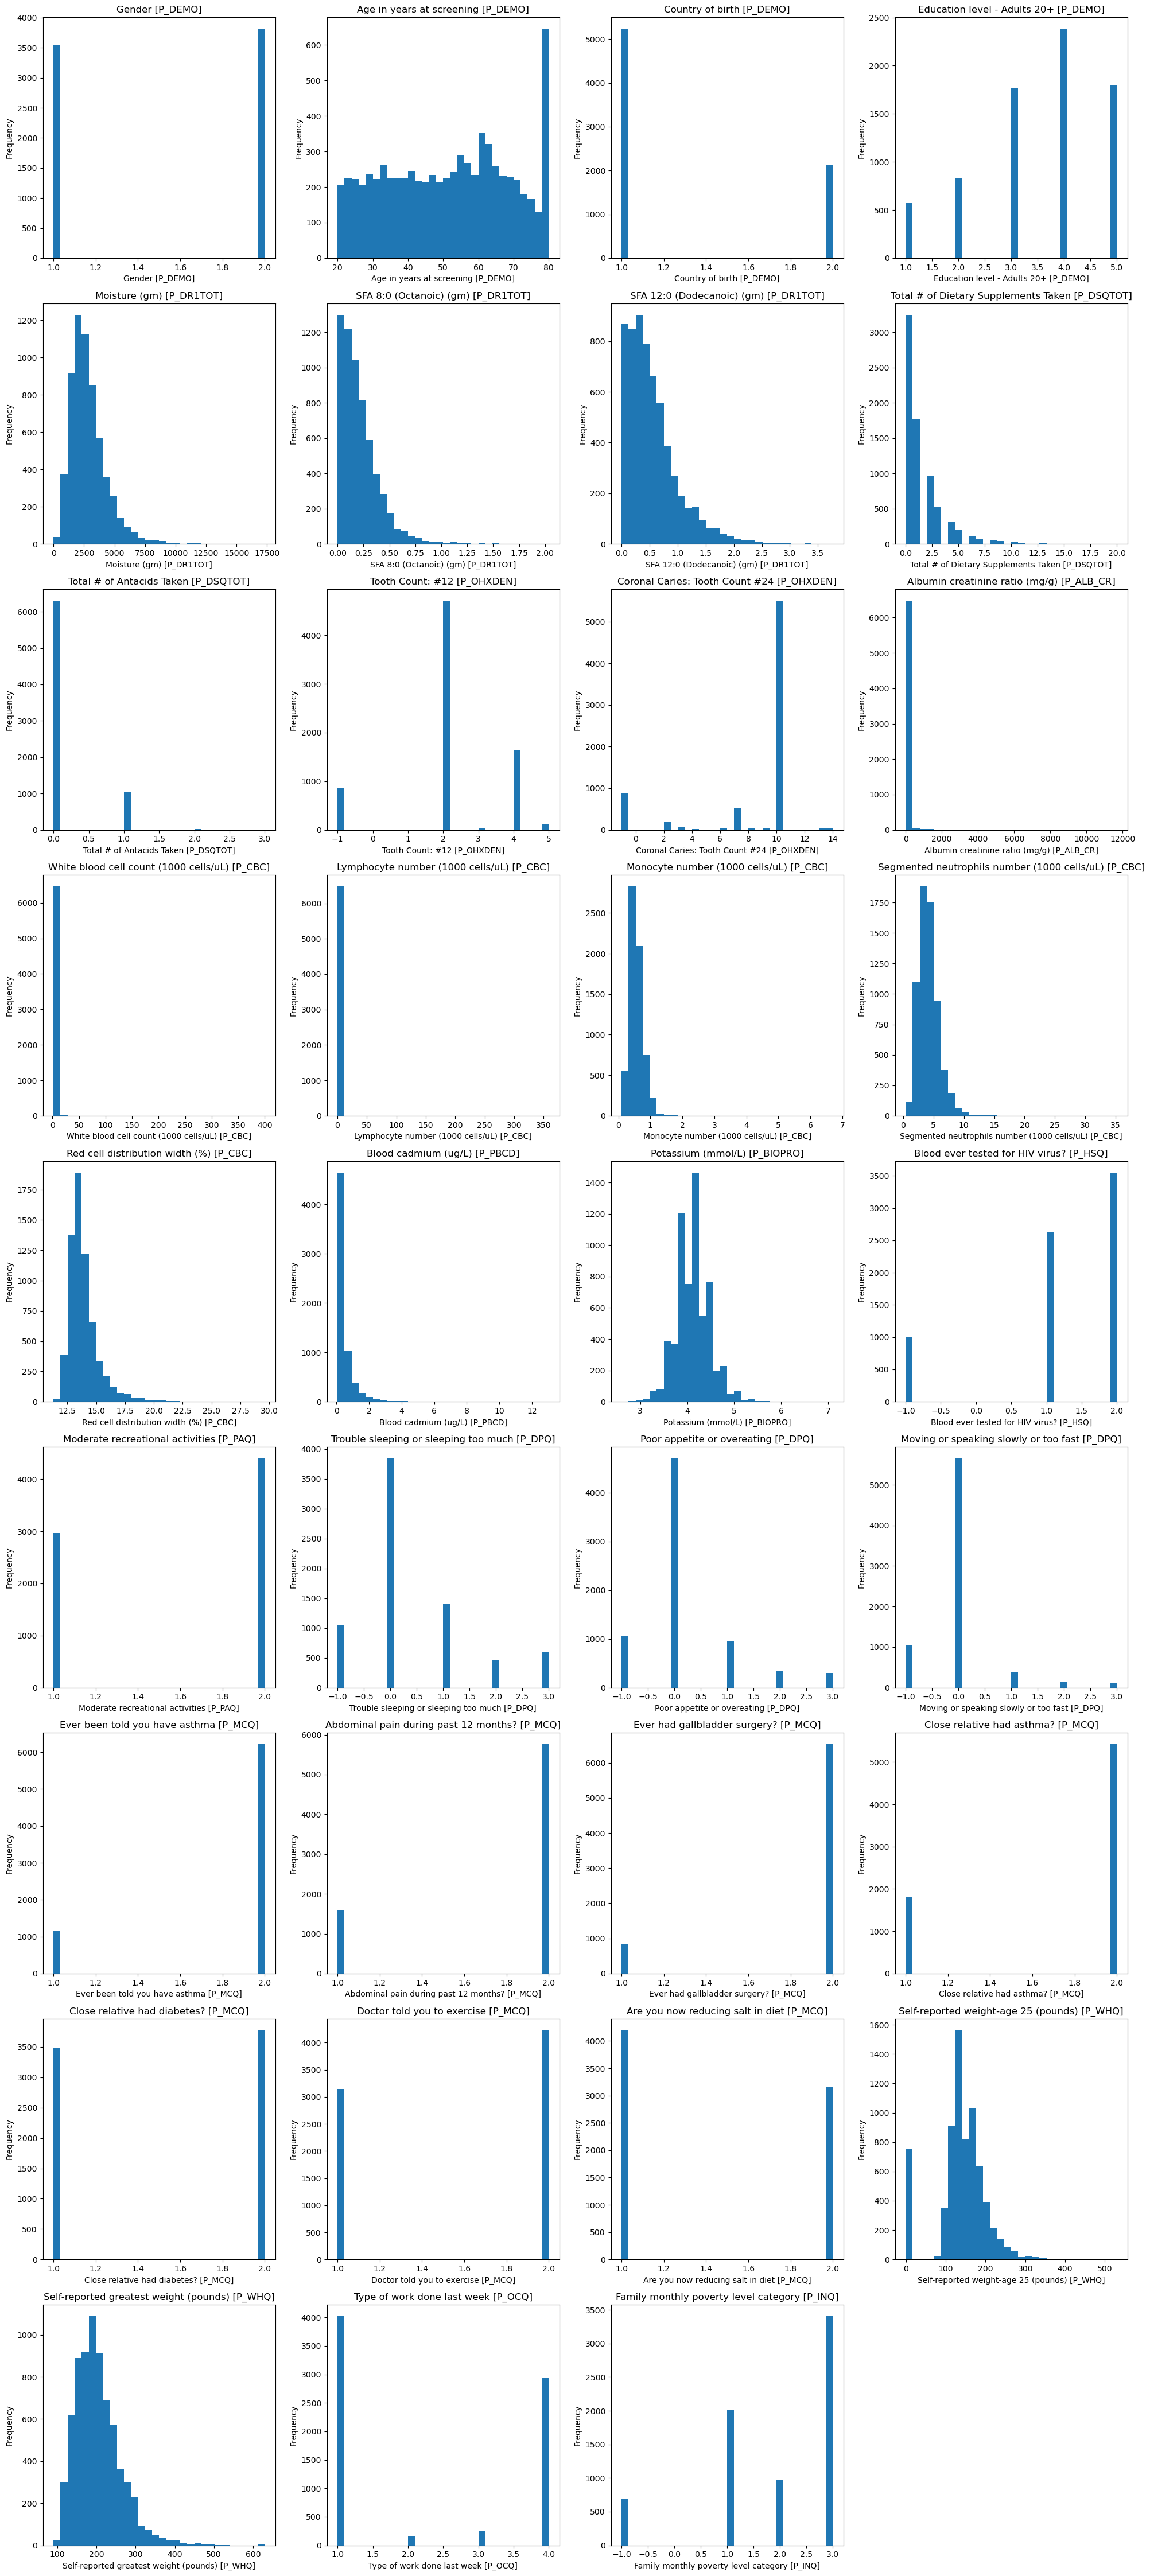

In [ ]:
# Assuming significant_features and fX_train_no_missing are defined
risk_factors = significant_features[1:]  # Exclude the intercept

# Define the columns to be log-transformed
log_transform_columns = [
    'SFA 8:0 (Octanoic) (gm) [P_DR1TOT]',
    'SFA 12:0 (Dodecanoic) (gm) [P_DR1TOT]'
]

# Apply the LogTransformer to the specific columns
log_transformer = LogTransformer(columns=log_transform_columns)
fX_train_transformed = log_transformer.transform(fX_train_no_missing)

# Number of columns in the list
num_columns = len(risk_factors)

# Number of rows needed for the 4-column grid layout
num_rows = (num_columns + 3) // 4

# Create a 4-column grid layout for plotting
fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the distribution for each column in risk_factors
for i, feature in enumerate(risk_factors):
    fX_train_transformed[feature].plot(kind='hist', ax=axes[i], bins=30, title=feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Influences

In [ ]:
influence = result.get_influence()
summary_frame = influence.summary_frame()
print(summary_frame)


### More validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(grid_search_logistic.best_estimator_, fX_train_no_missing, y_train_no_missing, cv=5, scoring='f1')
print("Cross-Validation F1 Scores:", scores)
print("Mean F1 Score:", scores.mean())

### Multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

X_train_vif = pd.DataFrame(X2[:, 1:], columns=feature_names[1:])  # Exclude intercept for VIF calculation
vif_df = calculate_vif(X_train_vif)
print(vif_df)


# Comprehensive Report on Risk Factors for Arthritis with Risk Indicators

The following analysis categorizes the identified risk factors for arthritis based on their statistical significance (p < 0.05). The factors are divided into several categories: environmental factors, known risk factors, early warning signs, ways to diagnose, and other relevant factors. For each factor, the conditions that increase the risk of arthritis are indicated.

## Disclaimer
P-values are a tried and true method for finding risk factors but a relationship does not guarantee it is a risk factor.  This is done with novice domain knowledge too and risk factors must be assessed by medical professionals and other experts past this.

## 1. Environmental Factors

### Behavioral and Lifestyle Factors
- **Smoked at least 100 cigarettes in life [P_SMQ]:** (Smoking increases risk) Smoking is a known risk factor for rheumatoid arthritis and other inflammatory conditions.
- **Are you now reducing salt in diet [P_MCQ]:** (Not reducing salt increases risk) High salt intake can influence inflammation and immune response, potentially contributing to arthritis.
- **Salt used in preparation? [P_DR1TOT]:** (More salt increases risk) Frequent use of salt in food preparation can contribute to high salt intake.
- **Alcohol (gm) [P_DR1TOT]:** (High alcohol intake increases risk) Excessive alcohol consumption can lead to inflammation and may be a trigger for arthritis.
- **Moderate recreational activities [P_PAQ]:** (Less activity increases risk) Lack of physical activity can contribute to obesity and joint stress, increasing arthritis risk.

### Dietary Factors
- **SFA 12:0 (Dodecanoic) (gm) [P_DR1TOT]:** (Higher intake increases risk) Higher intake of saturated fatty acids can contribute to inflammation.
- **Number of foods/beverages reported [P_DR1TOT]:** (Lower diversity or higher quantity increases risk) Limited dietary diversity can affect inflammation and overall health. Additionally, consuming a higher quantity of certain foods might also contribute to inflammation.
- **Moisture (gm) [P_DR1TOT]:** (Lower moisture content increases risk) Lower moisture content in diet can affect hydration status, impacting joint health.

### Occupational and Environmental Exposures
- **Type of work done last week [P_OCQ]:** (Physically demanding jobs increase risk) Certain types of work can stress joints and increase arthritis risk.
- **Blood manganese (ug/L) [P_PBCD]:** (Abnormal levels increase risk) Abnormal levels of manganese can affect joint health.
- **Blood lead comment code [P_PBCD]:** (High exposure increases risk) Exposure to lead and other heavy metals can be associated with inflammatory responses.
- **Blood cadmium comment code [P_PBCD]:** (High exposure increases risk) Cadmium exposure is linked to inflammation.

## 2. Well Known Risk Factors

- **HS C-Reactive Protein (mg/L) [P_HSCRP]:** (High levels increase risk) Elevated levels of C-reactive protein are associated with inflammation, a key factor in the development and progression of arthritis.
- **Body Measures Component Status Code [P_BMX]:** (High BMI increases risk) Body measurements such as BMI can indicate obesity, a known risk factor for arthritis.
- **Doctor ever said you were overweight [P_MCQ]:** (Yes increases risk) Obesity is a significant risk factor for arthritis.
- **Ever told you had thyroid problem [P_MCQ]:** (Yes increases risk) Thyroid dysfunction is associated with autoimmune conditions.

## 3. Possible Early Warning Signs

- **Glucose, refrigerated serum (mmol/L) [P_BIOPRO]:** (High levels increase risk) High glucose levels can indicate metabolic syndrome, linked to arthritis.
- **Iron, refrigerated serum (umol/L) [P_BIOPRO]:** (Low levels increase risk) Disrupted iron metabolism can be a sign of inflammation.
- **Lactate Dehydrogenase (LDH) (IU/L) [P_BIOPRO]:** (High levels increase risk) Elevated LDH levels can indicate tissue damage.
- **Red cell distribution width (%) [P_CBC]:** (High levels increase risk) High variability in red blood cell size can indicate inflammation.
- **Segmented neutrophils percent (%) [P_CBC]:** (High levels increase risk) Elevated levels can indicate an ongoing inflammatory process.
- **Monocyte number (1000 cells/uL) [P_CBC]:** (High levels increase risk) Elevated monocytes are a sign of inflammation.
- **Mean cell hemoglobin concentration (g/dL) [P_CBC]:** (Low levels increase risk) Changes can indicate anemia related to chronic disease.
- **Mean cell volume (fL) [P_CBC]:** (Low levels increase risk) Altered levels can suggest anemia.
- **Albumin, refrigerated serum (g/dL) [P_BIOPRO]:** (Low levels increase risk) Lower levels suggest chronic inflammation.
- **Albumin creatinine ratio (mg/g) [P_ALB_CR]:** (High levels increase risk) Elevated levels can indicate kidney issues related to inflammation.
- **Albumin, urine (ug/mL) [P_ALB_CR]:** (High levels increase risk) Indicates kidney function and systemic inflammation.
- **Globulin (g/dL) [P_BIOPRO]:** (High levels increase risk) Higher levels can be a marker of chronic inflammation.
- **Total Calcium (mg/dL) [P_BIOPRO]:** (High or low levels increase risk) Calcium imbalance can affect bone health.
- **Creatinine, refrigerated serum (mg/dL) [P_BIOPRO]:** (High levels increase risk) Indicates kidney function.
- **Potassium (mmol/L) [P_BIOPRO]:** (High or low levels increase risk) Imbalance can affect muscle and nerve function.
- **Iron frozen, Serum (umol/L) [P_FETIB]:** (Low levels increase risk) Reflects iron storage and metabolism.
- **Transferrin Saturation (%) [P_FETIB]:** (Low levels increase risk) Indicates iron availability in the body.
- **Trouble sleeping or sleeping too much [P_DPQ]:** (Yes increases risk) Sleep disturbances are common in arthritis patients.
- **Moving or speaking slowly or too fast [P_DPQ]:** (Yes increases risk) Psychomotor changes can be associated with chronic pain and depression in arthritis.
- **Poor appetite or overeating [P_DPQ]:** (Yes increases risk) Dietary habits can influence arthritis risk.
- **Abdominal pain during past 12 months? [P_MCQ]:** (Yes increases risk) Chronic pain can be an early sign of arthritis.
- **Self-reported greatest weight (pounds) [P_WHQ]:** (High weight increases risk) Weight history can indicate risk of obesity-related arthritis.
- **Self-reported weight-age 25 (pounds) [P_WHQ]:** (High weight increases risk) Historical weight can provide insights into long-term risk factors.

## 4. Possible Diagnosis Markers

- **HS C-Reactive Protein (mg/L) [P_HSCRP]:** (High levels) Inflammation marker used in diagnosis.
- **Glucose, refrigerated serum (mmol/L) [P_BIOPRO]:** (High levels) Screening for metabolic conditions.
- **Iron, refrigerated serum (umol/L) [P_BIOPRO]:** (Low levels) Inflammation and iron metabolism marker.
- **Lactate Dehydrogenase (LDH) (IU/L) [P_BIOPRO]:** (High levels) Tissue damage marker.
- **Albumin, refrigerated serum (g/dL) [P_BIOPRO]:** (Low levels) Chronic inflammation marker.
- **Albumin creatinine ratio (mg/g) [P_ALB_CR]:** (High levels) Kidney function and inflammation marker.
- **Albumin, urine (ug/mL) [P_ALB_CR]:** (High levels) Kidney function marker.
- **Globulin (g/dL) [P_BIOPRO]:** (High levels) Chronic inflammation marker.
- **Total Calcium (mg/dL) [P_BIOPRO]:** (High or low levels) Bone health marker.
- **Creatinine, refrigerated serum (mg/dL) [P_BIOPRO]:** (High levels) Kidney function marker.
- **Potassium (mmol/L) [P_BIOPRO]:** (High or low levels) Muscle and nerve function marker.
- **Iron frozen, Serum (umol/L) [P_FETIB]:** (Low levels) Iron storage and metabolism marker.
- **Transferrin Saturation (%) [P_FETIB]:** (Low levels) Iron availability marker.
- **Red cell distribution width (%) [P_CBC]:** (High levels) Inflammation marker.
- **Segmented neutrophils percent (%) [P_CBC]:** (High levels) Inflammation marker.
- **Monocyte number (1000 cells/uL) [P_CBC]:** (High levels) Inflammation marker.
- **Mean cell hemoglobin concentration (g/dL) [P_CBC]:** (Low levels) Anemia marker.
- **Mean cell volume (fL) [P_CBC]:** (Low levels) Anemia marker.

## 5. Other Relevant Factors

### Demographic Factors
- **Age in years at screening [P_DEMO]:** (Older age increases risk) Age is a well-known risk factor for arthritis.
- **Gender [P_DEMO]:** (Women are at higher risk) Gender can influence arthritis risk, with women being more prone to certain types.
- **Country of birth [P_DEMO]:** (Varies) Geographical and genetic factors may play a role in arthritis prevalence.
- **Education level - Adults 20+ [P_DEMO]:** (Lower education increases risk) Lower education levels are often associated with higher arthritis risk due to socioeconomic factors.
- **Family monthly poverty level category [P_INQ]:** (Lower income increases risk) Lower socioeconomic status is associated with higher arthritis risk due to limited access to healthcare and healthy lifestyle options.

### Medical History and Screening
- **Blood ever tested for HIV virus? [P_HSQ]:** (Positive result increases risk) Indicates the history of medical screening and potential immunocompromised status.
- **Hydroxycotinine, Serum Comment Code [P_COT]:** (Higher levels increase risk) Reflects smoking habits.
- **Total # of Antacids Taken [P_DSQTOT]:** (Higher usage increases risk) High usage of antacids can reflect gastrointestinal issues linked to arthritis.
- **Total # of Dietary Supplements Taken [P_DSQTOT]:** (Higher usage) Supplement use can indicate attempts to manage chronic conditions.

### Oral Health Indicators
- **Tooth Count: #2, #10, #12 [P_OHXDEN]:** (Fewer teeth increases risk) Reduced tooth count can indicate poor oral health, which is linked to systemic inflammation.
- **Coronal Caries: Tooth Count #2, #12, #29 [P_OHXDEN]:** (More caries increases risk) Dental caries are indicators of oral health, affecting overall health.
- **Dental Implant: yes / no? [P_OHXDEN]:** (Yes increases risk) Presence of dental implants indicates prior oral health issues.

### Family Medical History
- **Close relative had heart attack? [P_MCQ]:** (Yes increases risk) Family history of cardiovascular disease can be linked to inflammatory conditions.
- **Close relative had asthma? [P_MCQ]:** (Yes increases risk) Family history of asthma suggests a predisposition to autoimmune conditions.
- **Close relative had diabetes? [P_MCQ]:** (Yes increases risk) Family history of diabetes is linked to metabolic syndrome and inflammation.

### Self-Reported Health Conditions
- **Ever been told you have asthma [P_MCQ]:** (Yes increases risk) Asthma and other autoimmune conditions are associated with higher arthritis risk.
- **Ever had gallbladder surgery? [P_MCQ]:** (Yes increases risk) History of gallbladder issues can indicate metabolic problems.
